<a href="https://colab.research.google.com/github/AnastasiaZAYU/Data_Analysis_2023/blob/main/Lab4_DataAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Виконати наступне:
1. Завдання щодо генерації текстів або машинного перекладу на базі рекурентних мереж або трансформерів. Вирішіть завдання щодо генерації текстів або машинного перекладу. Особливо вітаються україномовні моделі.  

2. Проведіть експерименти з моделями бібліотеки HF Transformers за допомогою (наприклад) Pipeline модуля.Знайдіть українські мовні моделі, наведіть приклади роботи з ними.

3. Завдання щодо генерації або стилізації зображень (на вибір). Вирішіть завдання перенесення стилю або генерації зображень (архітектура за вашим вибором: GAN/DCGAN/VAE).

In [1]:
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 10.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.2 which is incompatible.


In [2]:
import keras
print(keras.__version__)

3.0.2


In [3]:
from keras import ops

In [4]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"
import numpy as np
import pathlib
import random
import string
import re

import tensorflow.data as tf_data
import tensorflow.strings as tf_strings

import keras
from keras import layers
from keras.layers import TextVectorization

import zipfile
import numpy as np
import tensorflow as tf

#from transformers import pipeline

from IPython.display import display
import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL.Image
import functools
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

## 1.  Машинний переклад на базі seq-to-seq трансформера

### Завантаження та очищення даних

In [5]:
zip_file_path = '/content/ukr-eng.zip'
extracted_folder = pathlib.Path('ukr-eng')
if not extracted_folder.exists():
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extracted_folder)
text_file = extracted_folder / 'ukr.txt'

In [6]:
with open(text_file, 'r+') as file:
    lines = file.readlines()
    for i, line in enumerate(lines):
        columns = line.split('\t')
        updated_line = '\t'.join(columns[:-1]) + '\n'
        lines[i] = updated_line
    file.seek(0)
    file.writelines(lines)
    file.truncate()

### Розділення даних на пари речень

In [7]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, ukr = line.split("\t")
    ukr = "[start] " + ukr + " [end]"
    text_pairs.append((eng, ukr))

In [8]:
for _ in range(5):
    print(random.choice(text_pairs))

('Is it a problem?', '[start] Це проблема? [end]')
("Tom is there, isn't he?", '[start] Том же там? [end]')
('How did you get that scar on your chin?', '[start] Звідки у тебе цей шрам на підборідді? [end]')
("She's eight years old.", '[start] Їй вісім. [end]')
("I'm not busy tonight.", '[start] Сьогодні ввечері я вільний. [end]')


### Розділення даних на train, validation та test

In [9]:
random.shuffle(text_pairs)
num_val_samples = int(0.2 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

158705 total pairs
95223 training pairs
31741 validation pairs
31741 test pairs


### Векторизація текстових даних

In [10]:
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

vocab_size = 5000
sequence_length = 15
batch_size = 64

In [11]:
def custom_standardization(input_string):
    lowercase = tf_strings.lower(input_string)
    return tf_strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [12]:
eng_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
)

In [13]:
ukr_vectorization = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length + 1,
    standardize=custom_standardization,
)

In [14]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_ukr_texts = [pair[1] for pair in train_pairs]
eng_vectorization.adapt(train_eng_texts)
ukr_vectorization.adapt(train_ukr_texts)

### Форматування набору даних

In [15]:
def format_dataset(eng, ukr):
    eng = eng_vectorization(eng)
    ukr = ukr_vectorization(ukr)
    return (
        {
            "encoder_inputs": eng,
            "decoder_inputs": ukr[:, :-1],
        },
        ukr[:, 1:],
    )

In [16]:
def make_dataset(pairs):
    eng_texts, ukr_texts = zip(*pairs)
    eng_texts = list(eng_texts)
    ukr_texts = list(ukr_texts)
    dataset = tf_data.Dataset.from_tensor_slices((eng_texts, ukr_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset)
    return dataset.cache().shuffle(2048).prefetch(16)

In [17]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [18]:
for inputs, targets in train_ds.take(1):
    print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
    print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
    print(f"targets.shape: {targets.shape}")

inputs["encoder_inputs"].shape: (64, 15)
inputs["decoder_inputs"].shape: (64, 15)
targets.shape: (64, 15)


### Побудова моделі

In [19]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(dense_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
        else:
            padding_mask = None

        attention_output = self.attention(
            query=inputs, value=inputs, key=inputs, attention_mask=padding_mask
        )
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "dense_dim": self.dense_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [20]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim
        )
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=embed_dim
        )
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim

    def call(self, inputs):
        length = ops.shape(inputs)[-1]
        positions = ops.arange(0, length, 1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    def compute_mask(self, inputs, mask=None):
        if mask is None:
            return None
        else:
            return ops.not_equal(inputs, 0)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "sequence_length": self.sequence_length,
                "vocab_size": self.vocab_size,
                "embed_dim": self.embed_dim,
            }
        )
        return config

In [21]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.attention_2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim
        )
        self.dense_proj = keras.Sequential(
            [
                layers.Dense(latent_dim, activation="relu"),
                layers.Dense(embed_dim),
            ]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = ops.cast(mask[:, None, :], dtype="int32")
            padding_mask = ops.minimum(padding_mask, causal_mask)
        else:
            padding_mask = None

        attention_output_1 = self.attention_1(
            query=inputs, value=inputs, key=inputs, attention_mask=causal_mask
        )
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(
            query=out_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = ops.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = ops.arange(sequence_length)[:, None]
        j = ops.arange(sequence_length)
        mask = ops.cast(i >= j, dtype="int32")
        mask = ops.reshape(mask, (1, input_shape[1], input_shape[1]))
        mult = ops.concatenate(
            [ops.expand_dims(batch_size, -1), ops.convert_to_tensor([1, 1])],
            axis=0,
        )
        return ops.tile(mask, mult)

    def get_config(self):
        config = super().get_config()
        config.update(
            {
                "embed_dim": self.embed_dim,
                "latent_dim": self.latent_dim,
                "num_heads": self.num_heads,
            }
        )
        return config

In [23]:
embed_dim = 64
latent_dim = 256
num_heads = 5

encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="encoder_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, latent_dim, num_heads)(x)
encoder = keras.Model(encoder_inputs, encoder_outputs)

decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="decoder_inputs")
encoded_seq_inputs = keras.Input(shape=(None, embed_dim), name="decoder_state_inputs")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, latent_dim, num_heads)(x, encoded_seq_inputs)
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)
decoder = keras.Model([decoder_inputs, encoded_seq_inputs], decoder_outputs)

decoder_outputs = decoder([decoder_inputs, encoder_outputs])
transformer = keras.Model(
    [encoder_inputs, decoder_inputs], decoder_outputs, name="transformer"
)

In [24]:
epochs = 7  # This should be at least 30 for convergence

transformer.summary()
transformer.compile(
    "rmsprop", loss="sparse_categorical_crossentropy", metrics=["accuracy"]
)
transformer.fit(train_ds, epochs=epochs, validation_data=val_ds)

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃    Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ encoder_inputs            │ (None, None)           │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ positional_embedding_2    │ (None, None, 64)       │    320,960 │ encoder_inputs[0][0]       │
│ (PositionalEmbedding)     │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ decoder_inputs            │ (None, None)           │          0 │ -                          │
│ (InputLayer)              │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ transformer_encoder_1     │ (None, None, 64)       │    116,288 │ positional_embedding_2[0]… │
│ (TransformerEncoder)      │                        │            │                            │
├───────────────────────────┼────────────────────────┼────────────┼────────────────────────────┤
│ functional_11             │ (None, None, 5000)     │    845,320 │ decoder_inputs[0][0],      │
│ (Functional)              │                        │            │ transformer_encoder_1[0][… │
└───────────────────────────┴────────────────────────┴────────────┴────────────────────────────┘

 Total params: 1,282,568 (4.89 MB)

 Trainable params: 1,282,568 (4.89 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 311s 206ms/step - accuracy: 0.7172 - loss: 2.4986 - val_accuracy: 0.8084 - val_loss: 1.2720
Epoch 2/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 299s 201ms/step - accuracy: 0.8072 - loss: 1.2839 - val_accuracy: 0.8313 - val_loss: 1.0406
Epoch 3/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 302s 203ms/step - accuracy: 0.8261 - loss: 1.1135 - val_accuracy: 0.8431 - val_loss: 0.9691
Epoch 4/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 319s 201ms/step - accuracy: 0.8350 - loss: 1.0449 - val_accuracy: 0.8466 - val_loss: 0.9513
Epoch 5/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 312s 210ms/step - accuracy: 0.8391 - loss: 1.0225 - val_accuracy: 0.8490 - val_loss: 0.9386
Epoch 6/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 297s 200ms/step - accuracy: 0.8418 - loss: 1.0088 - val_accuracy: 0.8475 - val_loss: 0.9611
Epoch 7/7
1488/1488 ━━━━━━━━━━━━━━━━━━━━ 324s 201ms/step - accuracy: 0.8223 - loss: 1.1575 - val_accuracy: 0.7145 - val_loss: 1.9533


In [25]:
ukr_vocab = ukr_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(ukr_vocab)), ukr_vocab))
max_decoded_sentence_length = 20


def decode_sequence(input_sentence):
    tokenized_input_sentence = eng_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = ukr_vectorization([decoded_sentence])[:, :-1]
        predictions = transformer([tokenized_input_sentence, tokenized_target_sentence])

        # ops.argmax(predictions[0, i, :]) is not a concrete value for jax here
        sampled_token_index = ops.convert_to_numpy(
            ops.argmax(predictions[0, i, :])
        ).item(0)
        sampled_token = spa_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token

        if sampled_token == "[end]":
            break
    return decoded_sentence


test_eng_texts = [pair[0] for pair in test_pairs]
for _ in range(10):
    input_sentence = random.choice(test_eng_texts)
    translated = decode_sequence(input_sentence)
    print(input_sentence + " " + translated)

Was the door open? [start] [UNK] [UNK] [end]
Don't talk to Tom. [start] Я [UNK] [UNK] [end]
I nodded. [start] Я [UNK] [UNK] [end]
Please help Tom. [start] Я [UNK] [UNK] [end]
I did nothing wrong. [start] Я [UNK] [UNK] [UNK] [end]
Today is very warm. [start] Том [UNK] [end]
I didn't permit Tom to do that. [start] Я [UNK] [UNK] [UNK] [end]
I didn't want to waste my time. [start] Я [UNK] [UNK] [UNK] [UNK] [UNK] [end]
They went fishing. [start] [UNK] [UNK] [UNK] [end]
I know Tom is gullible. [start] Том [UNK] [UNK] [end]


## 2.  Експерименти з моделями бібліотеки HF Transformers за допомогою Pipeline модуля

### Узагальнення тексту

In [5]:
summarizer = pipeline("summarization", model='ukr-models/uk-summarizer')

In [6]:
text = """При цьому собака – істота дуже соціальна, яка легко йде на зближення хоч із сусідським бобиком, хоч із домашнім півнем.
Коли собака бачить кішку, їй цікаво, що це за істота. При цьому кіт намагається в цей момент втекти, тим самим провокуючи собаку «відкрити полювання».
Кіт може навіть випустити пазурі і дати боляче лапою по дружньому та цікавому носу.
Все перераховане може стати причиною величезної ворожості один до одного як одного вихованця, так й іншого."""

In [7]:
summarizer(text, max_length=20, min_length=5)

[{'summary_text': 'Кіт і собака часто стикаються з ворожістю, а '}]

### Заповнення пропуску в тексті

In [ ]:
unmasker = pipeline('fill-mask', model='xlm-roberta-base')

In [14]:
text = "Моя собака сьогодні цілий день <mask>."

In [15]:
unmasker(text)

[{'score': 0.0796356126666069,
  'token': 77482,
  'token_str': 'працює',
  'sequence': 'Моя собака сьогодні цілий день працює.'},
 {'score': 0.05688196420669556,
  'token': 206189,
  'token_str': 'вдома',
  'sequence': 'Моя собака сьогодні цілий день вдома.'},
 {'score': 0.050869379192590714,
  'token': 5,
  'token_str': '.',
  'sequence': 'Моя собака сьогодні цілий день..'},
 {'score': 0.0484209842979908,
  'token': 35638,
  'token_str': 'живе',
  'sequence': 'Моя собака сьогодні цілий день живе.'},
 {'score': 0.0399322547018528,
  'token': 22589,
  'token_str': 'одна',
  'sequence': 'Моя собака сьогодні цілий день одна.'}]

## 3. Стилізація зображень

In [2]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [3]:
content_path = 'image.jpg'
style_path = 'style.jpg'

In [4]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [5]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

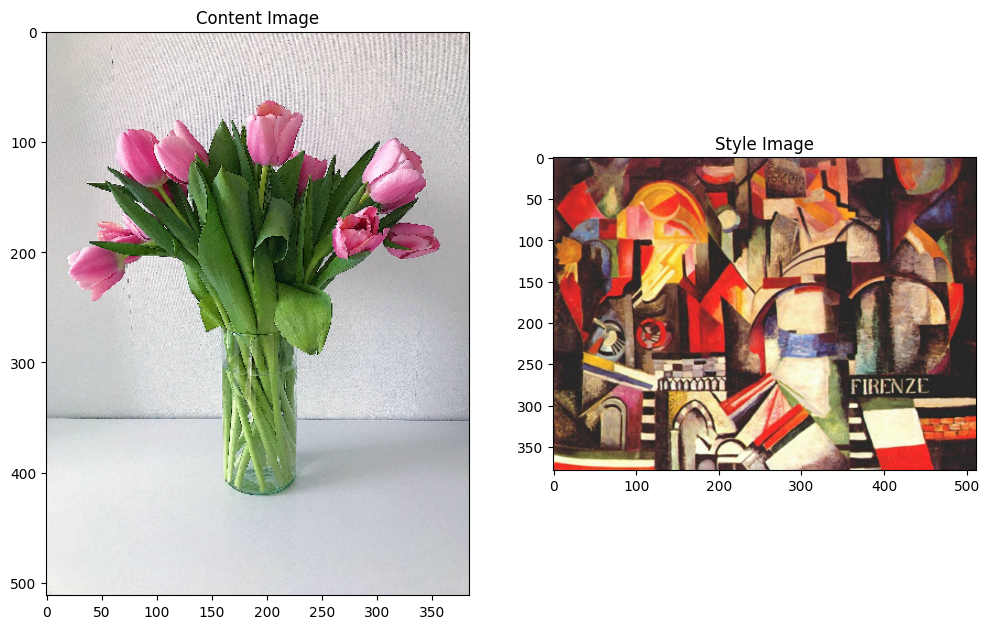

In [6]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [7]:
content_layers = ['block5_conv2']

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [8]:
def vgg_layers(layer_names):
  """ Creates a VGG model that returns a list of intermediate output values."""
  # Load our model. Load pretrained VGG, trained on ImageNet data
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [9]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [10]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg = vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [11]:
extractor = StyleContentModel(style_layers, content_layers)

80134624/80134624 [==============================] - 0s 0us/step


In [12]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [13]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [14]:
style_weight=1e-2
content_weight=1e4

In [15]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2)
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2)
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [16]:
total_variation_weight=30

In [17]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [18]:
opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
image = tf.Variable(content_image)

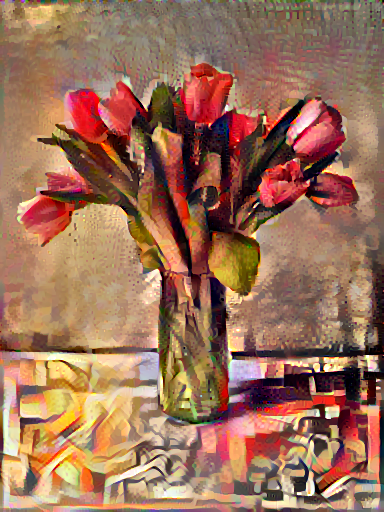

Train step: 1000


In [ ]:
epochs = 10
steps_per_epoch = 100

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))